# ArviZ migration guide

We have been working on refactoring ArviZ to allow more flexibility and extensibility of its elements
while keeping as much as possible a friendly user-interface that gives sensible results with little to no arguments.

One important change is enhanced modularity. Everything will still be available through a common namespace `arviz`,
but ArviZ will now be composed of 3 smaller libraries:

* `arviz-base` for general functionality, data related functionality and converters.
* `arviz-stats` for statistical summaries, diagnostics, metrics and other estimators.
* `arviz-plots` for visual checks built on top of `arviz-stats`

Each library depends only on a minimal set of libraries, with a lot of functionality built on top of optional dependencies.
This keeps ArviZ smaller and easier to install as you can install only the components you really need. The main examples are:

* `arviz-base` has no I/O library as a dependency, but you can use `netcdf4`, `h5netcdf` or `zarr` to read and write your data, installing only the one you need.
* `arviz-plots` has no plotting library as a dependency, but it can generate plots with `matplotlib`, `bokeh` or `plotly` if they are installed.

At the time of writing, `arviz-xyz` libraries are independent of the `arviz` library, but `arviz` tries to import the `arviz-xyz` libraries
and exposes all their elements through the `arviz.preview` namespace. In the future, with the ArviZ 1.0 release, the `arviz` namespace will look
like `arviz.preview` looks like today.

We encourage you to try it out and get a head start on the migration!

In [1]:
import arviz.preview as az
# change to import arviz as az after ArviZ 1.0 release

Check all 3 libraries have been exposed correctly:

In [2]:
print(az.info)

arviz_base available, exposing its functions as part of arviz.preview
arviz_stats available, exposing its functions as part of arviz.preview
arviz_plots available, exposing its functions as part of arviz.preview



## `arviz-base`

### `DataTree`

#### I already have `InferenceData` object from an external library
`InferenceData` already has a method to convert it to DataTree.

In [3]:
import arviz as arviz_legacy

In [4]:
idata = arviz_legacy.load_arviz_data("centered_eight")

In [5]:
idata.to_datatree()

<xarray.DataTree>
Group: /
├── Group: /posterior
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           mu       (chain, draw) float64 16kB ...
│           theta    (chain, draw, school) float64 128kB ...
│           tau      (chain, draw) float64 16kB ...
│       Attributes:
│           created_at:                 2022-10-13T14:37:37.315398
│           arviz_version:              0.13.0.dev0
│           inference_library:          pymc
│           inference_library_version:  4.2.2
│           sampling_time:              7.480114936828613
│           tuning_steps:               1000
├── Group: /posterior_predictive
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:41.460544
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /log_likelihood
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:37.487399
│           inference_library:          pymc
│           inference_library_version:  4.2.2
...
├── Group: /prior_predictive
│       Dimensions:  (chain: 1, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 32kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.604969
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /observed_data
│       Dimensions:  (school: 8)
│       Coordinates:
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (school) float64 64B ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.606375
│           inference_library:          pymc
│           inference_library_version:  4.2.2
└── Group: /constant_data
        Dimensions:  (school: 8)
        Coordinates:
          * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
        Data variables:
            scores   (school) float64 64B ...
        Attributes:
            arviz_version:              0.13.0.dev0
            created_at:                 2022-10-13T14:37:26.607471
            inference_library:          pymc
            inference_library_version:  4.2.2

#### What about my existing netcdf/zarr files?
They are as valid as before, if anything, using xarray directly will give you better I/O as all arguments related to encoding, chunks... are now directly exposed.

In [6]:
idata.to_netcdf("example.nc")

'example.nc'

In [7]:
from xarray import open_datatree
dt = open_datatree("example.nc")
dt

<xarray.DataTree>
Group: /
├── Group: /posterior
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           mu       (chain, draw) float64 16kB ...
│           theta    (chain, draw, school) float64 128kB ...
│           tau      (chain, draw) float64 16kB ...
│       Attributes:
│           created_at:                 2022-10-13T14:37:37.315398
│           arviz_version:              0.13.0.dev0
│           inference_library:          pymc
│           inference_library_version:  4.2.2
│           sampling_time:              7.480114936828613
│           tuning_steps:               1000
├── Group: /posterior_predictive
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:41.460544
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /log_likelihood
│       Dimensions:  (chain: 4, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 32B 0 1 2 3
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 128kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:37.487399
│           inference_library:          pymc
│           inference_library_version:  4.2.2
...
├── Group: /prior_predictive
│       Dimensions:  (chain: 1, draw: 500, school: 8)
│       Coordinates:
│         * chain    (chain) int64 8B 0
│         * draw     (draw) int64 4kB 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (chain, draw, school) float64 32kB ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.604969
│           inference_library:          pymc
│           inference_library_version:  4.2.2
├── Group: /observed_data
│       Dimensions:  (school: 8)
│       Coordinates:
│         * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
│       Data variables:
│           obs      (school) float64 64B ...
│       Attributes:
│           arviz_version:              0.13.0.dev0
│           created_at:                 2022-10-13T14:37:26.606375
│           inference_library:          pymc
│           inference_library_version:  4.2.2
└── Group: /constant_data
        Dimensions:  (school: 8)
        Coordinates:
          * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
        Data variables:
            scores   (school) float64 64B ...
        Attributes:
            arviz_version:              0.13.0.dev0
            created_at:                 2022-10-13T14:37:26.607471
            inference_library:          pymc
            inference_library_version:  4.2.2

## Enhanced converter flexibility
Were you constantly needing to add extra axis to your data because it doesn't have any `chain` dimension?

In [8]:
import numpy as np
rng = np.random.default_rng()
data = rng.normal(size=1000)

In [9]:
# az.from_dict({"posterior": {"mu": data}}) would fail unless you did data[None, :] to add the chain dimension
az.rcParams["data.sample_dims"] = "sample"

In [11]:
dt = az.from_dict({"posterior": {"mu": data}})
dt

<xarray.DataTree>
Group: /
└── Group: /posterior
        Dimensions:  (sample: 1000)
        Coordinates:
          * sample   (sample) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
        Data variables:
            mu       (sample) float64 8kB 0.6341 0.1603 -0.2955 ... -0.3039 0.4061
        Attributes:
            created_at:                 2025-05-26T22:24:41.597038+00:00
            creation_library:           ArviZ
            creation_library_version:   0.6.0.dev0
            creation_library_language:  Python

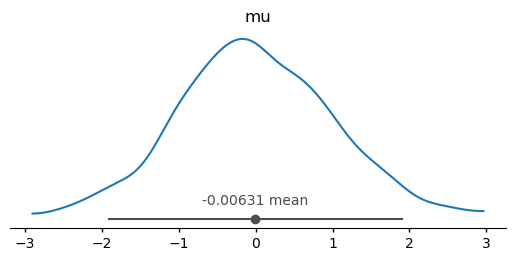

In [12]:
# arviz-stats and arviz-plots also take it into account
az.plot_dist(dt);

### New data wrangling features

## `arviz-stats`

## `arviz-plots`

Out of the 3 libraries, `arviz-plots` is the one with the most changes at all levels, breaking changes, new features more layers to explore.

The following functions have been renamed:

* `plot_posterior`, `plot_density` -> `plot_dist`
* `plot_trace` -> `plot_trace_dist`, `plot_trace_rank`
* `plot_ppc` -> `plot_ppc_dist`

The following functions have been added:

* `plot_trace`

And some functions have been removed too:

* `plot_dist`
* `plot_kde`

You can see all of them at the [arviz-plots gallery](https://arviz-plots.readthedocs.io/en/latest/gallery/index.html)